## Forecasting **UK Electricity prices** using RNN, CNN and LSTM in tensor flow (Univariate Time series) 

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
import tensorflow as tf


In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
import pandas as pd
df=pd.read_csv("../Data/electricity-prices.csv",index_col=[0], parse_dates=[0])
df.head(3)

,Price,Volume,Settlement Period,hour,quarter,year,dayofyear,dayofmonth,weekofyear,SAP,EU_ETS,Gas,INDO
datetime,,,,,,,,,,,,,
2017-01-01 00:00:00,44.90,505.00,1,0.0,1.0,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27239
2017-01-01 00:30:00,47.13,559.15,2,0.0,1.0,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27814
2017-01-01 01:00:00,45.62,649.35,3,1.0,1.0,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27453


In [7]:

def limit(data, frm, to):
    return data[(data.index>=frm)&(data.index<to)]

In [8]:
new_df = limit(df,'2019-01-01', '2019-06-30')

In [9]:
new_df.shape

(8530, 13)

In [10]:
new_df=new_df[['Price']]

In [11]:
new_df.head()

,Price
datetime,
2019-01-01 00:00:00,48.81
2019-01-01 00:30:00,50.24
2019-01-01 01:00:00,41.90
2019-01-01 01:30:00,39.32
2019-01-01 02:00:00,34.09


In [12]:
#new_df.to_csv('../Data/small_elec.csv')

In [13]:
new_df.head(3)

,Price
datetime,
2019-01-01 00:00:00,48.81
2019-01-01 00:30:00,50.24
2019-01-01 01:00:00,41.90


In [14]:
df.sort_index(inplace=True)

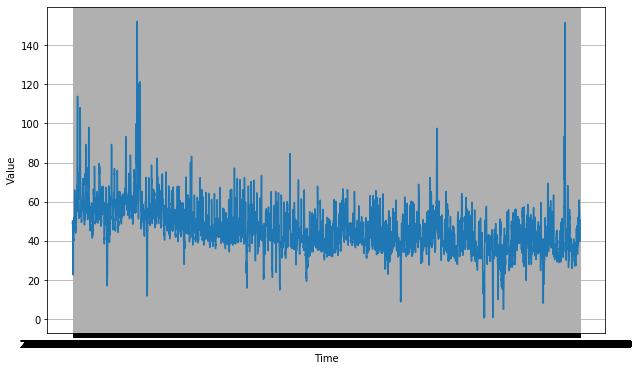

In [15]:
import csv
time_step = []
elec_prices = []

with open('../Data/small_elec.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    elec_prices.append(float(row[1]))
    time_step.append(str(row[0]))

series = np.array(elec_prices)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [54]:
split_time = 7810 #7484 #7810 # Train 01 -01 -2019 test: 15 -06 -2019 25912
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 10000

In [7]:
#time_valid

In [56]:
len(series)

8530

# 1. Simple RNN Model:

In [31]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [32]:
tf.keras.backend.clear_session()
tf.compat.v2.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=2e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=43, callbacks=[lr_schedule])
model.save('univariate-ts-rnn.h5')

Epoch 1/43
59/59 [==============================] - 2s 35ms/step - loss: 205.3125 - mae: 205.8691
Epoch 2/43
59/59 [==============================] - 1s 24ms/step - loss: 193.1917 - mae: 193.7777
Epoch 3/43
59/59 [==============================] - 1s 19ms/step - loss: 177.4379 - mae: 178.0861
Epoch 4/43
59/59 [==============================] - 1s 20ms/step - loss: 155.9876 - mae: 156.6771
Epoch 5/43
59/59 [==============================] - 1s 20ms/step - loss: 122.7912 - mae: 123.5597
Epoch 6/43
59/59 [==============================] - 1s 19ms/step - loss: 66.1664 - mae: 67.0551
Epoch 7/43
59/59 [==============================] - 1s 20ms/step - loss: 19.8462 - mae: 20.3505
Epoch 8/43
59/59 [==============================] - 1s 20ms/step - loss: 13.8051 - mae: 14.2877
Epoch 9/43
59/59 [==============================] - 1s 20ms/step - loss: 11.4290 - mae: 11.9559
Epoch 10/43
59/59 [==============================] - 1s 20ms/step - loss: 8.8161 - mae: 9.3339
Epoch 11/43
59/59 [============

[1e-08, 0.0001, 0, 60]

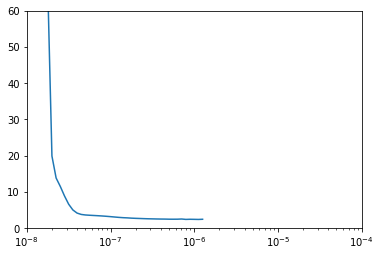

In [33]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

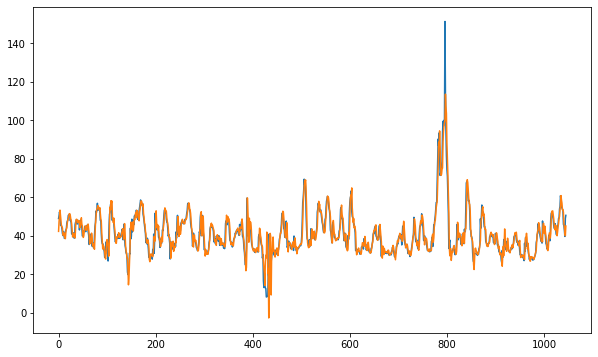

In [34]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


#plt.figure(figsize=(10, 6))

#plot_series(time_valid, x_valid)
#plot_series(time_valid, results)
from matplotlib import pyplot
pyplot.figure(figsize=(10, 6))
pyplot.plot( x_valid)
pyplot.plot(results)
pyplot.show()

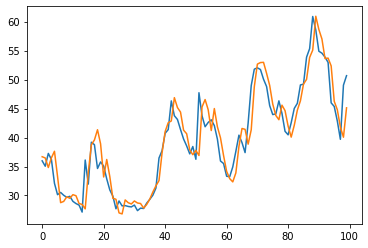

In [35]:
pyplot.plot(x_valid[-100:])
pyplot.plot(results[-100:])
pyplot.show()

In [36]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse,rmse
error1 = mse(x_valid, results)
error2 = rmse(x_valid, results)
error3 = mean_absolute_error(x_valid, results)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(x_valid), np.array(results)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error4 = mean_absolute_percentage_error(x_valid, results)

print(f'MAE Error: {error3:11.10}') 
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print(f'MAPE Error: {error4:11.10}')


MAE Error: 2.896508185
MSE Error : 23.07096422
RMSE Error: 4.803224356
MAPE Error: 8.244690044


# 2. The model with LSTM + convolutional layer on top

In [58]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [59]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [60]:
tf.keras.backend.clear_session()
tf.compat.v2.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None,1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=70)
#model.save('univariate-ts-lstm-cnn.h5')

Epoch 1/70
78/78 [==============================] - 8s 98ms/step - loss: 8.6142 - mae: 9.1220
Epoch 2/70
78/78 [==============================] - 5s 69ms/step - loss: 4.1443 - mae: 4.6065
Epoch 3/70
78/78 [==============================] - 5s 68ms/step - loss: 3.7393 - mae: 4.2001
Epoch 4/70
78/78 [==============================] - 6s 72ms/step - loss: 3.4849 - mae: 3.9413
Epoch 5/70
78/78 [==============================] - 6s 74ms/step - loss: 3.2928 - mae: 3.7481
Epoch 6/70
78/78 [==============================] - 6s 73ms/step - loss: 3.1357 - mae: 3.5901
Epoch 7/70
78/78 [==============================] - 6s 71ms/step - loss: 3.0000 - mae: 3.4524
Epoch 8/70
78/78 [==============================] - 6s 71ms/step - loss: 2.8906 - mae: 3.3415
Epoch 9/70
78/78 [==============================] - 6s 76ms/step - loss: 2.7916 - mae: 3.2379
Epoch 10/70
78/78 [==============================] - 6s 76ms/step - loss: 2.6532 - mae: 3.0977
Epoch 11/70
78/78 [==============================] - 5s 67m

In [61]:
model.save('univariate-ts-lstm-cnn-01.h5')

In [27]:
#model = tf.keras.models.load_model('models/univariate-ts-lstm-cnn.h5')

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [65]:
lstm_forecast = model_forecast(model, series[..., np.newaxis], window_size)
lstm_forecast = lstm_forecast[split_time - window_size:-1, -1, 0]

In [0]:
#plt.figure(figsize=(10, 6))
#plot_series(time_valid, x_valid)
#plot_series(time_valid, rnn_forecast)

In [8]:
#time_valid

In [67]:
test_data = {'dt':time_valid, 'actual':x_valid}

In [68]:
test_data = pd.DataFrame(test_data)

In [72]:
pred_data = {'dt':time_valid, 'predictions':lstm_forecast}

In [73]:
pred_data = pd.DataFrame(pred_data)

In [74]:
test = test_data.set_index('dt').actual

In [75]:
predictions = pred_data.set_index('dt').predictions

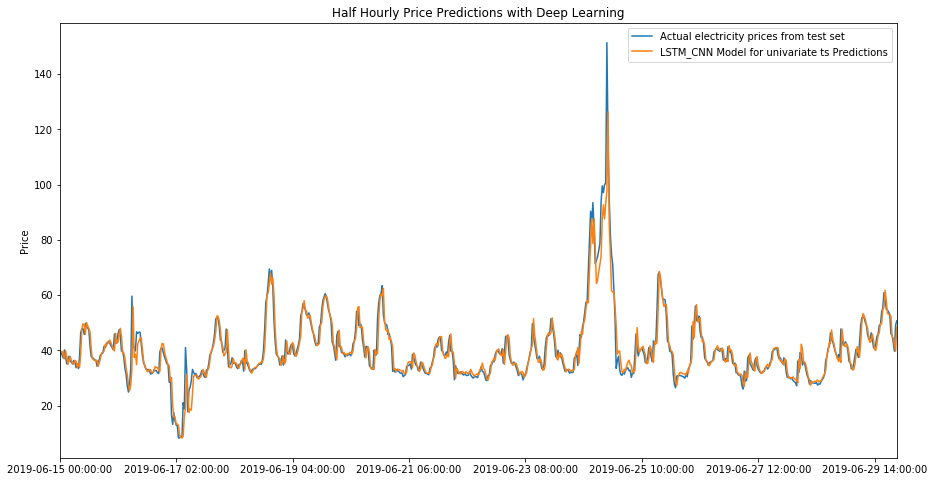

In [81]:
title = 'Half Hourly Price Predictions with Deep Learning'
ylabel='Price'
xlabel='' 
ax = test.rename('Actual electricity prices from test set').plot(legend=True,figsize=(15,8),title=title)
predictions.rename('LSTM_CNN Model for univariate ts Predictions').plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

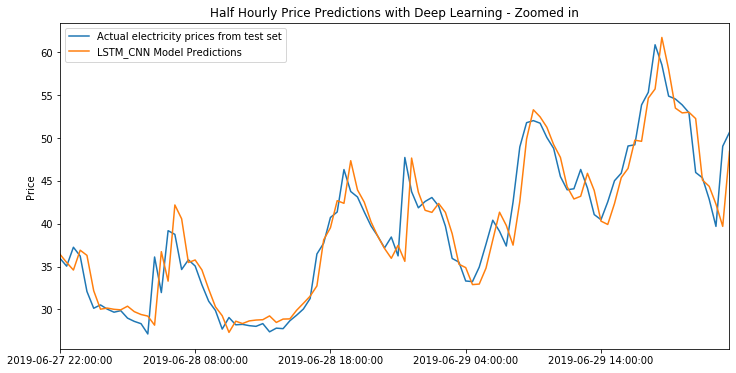

In [78]:
title = 'Half Hourly Price Predictions with Deep Learning - Zoomed in'
ylabel='Price'
xlabel='' 
ax = test[-100:].rename('Actual electricity prices from test set').plot(legend=True,figsize=(12,6),title=title)
predictions[-100:].rename('LSTM_CNN Model Predictions').plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [0]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse,rmse
error1 = mse(x_valid, rnn_forecast)
error2 = rmse(x_valid, rnn_forecast)
error3 = mean_absolute_error(x_valid, rnn_forecast)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(x_valid), np.array(rnn_forecast)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
error4 = mean_absolute_percentage_error(x_valid, rnn_forecast)

print(f'MAE Error: {error3:11.10}') 
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print(f'MAPE Error: {error4:11.10}')


MAE Error: 2.466151943
MSE Error : 18.36779643
RMSE Error: 4.285766726
MAPE Error: 6.017219084


In [80]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse,rmse
error1 = mse(x_valid, lstm_forecast)
error2 = rmse(x_valid, lstm_forecast)
error3 = mean_absolute_error(x_valid, lstm_forecast)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(x_valid), np.array(lstm_forecast)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
error4 = mean_absolute_percentage_error(x_valid, lstm_forecast)

print(f'MAE Error: {error3:11.10}') 
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print(f'MAPE Error: {error4:11.10}')


MAE Error: 2.465910798
MSE Error : 18.37080372
RMSE Error: 4.286117558
MAPE Error: 6.016250226


<Figure size 432x288 with 0 Axes>

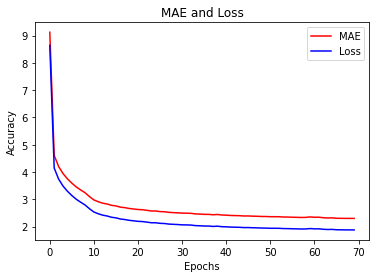

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

plt.figure()


# 3. The model with only LSTM:

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [21]:

tf.keras.backend.clear_session()
tf.compat.v2.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=60, callbacks=[lr_schedule])
model.save('univariate-ts-lstm.h5')

Epoch 1/60
244/244 [==============================] - 8s 32ms/step - loss: 16.8610 - mae: 17.3707
Epoch 2/60
244/244 [==============================] - 3s 13ms/step - loss: 11.3207 - mae: 11.8217
Epoch 3/60
244/244 [==============================] - 3s 13ms/step - loss: 9.5324 - mae: 10.0004
Epoch 4/60
244/244 [==============================] - 3s 13ms/step - loss: 8.7999 - mae: 9.3052
Epoch 5/60
244/244 [==============================] - 3s 13ms/step - loss: 8.5293 - mae: 9.0248
Epoch 6/60
244/244 [==============================] - 3s 13ms/step - loss: 8.3931 - mae: 8.8821
Epoch 7/60
244/244 [==============================] - 3s 13ms/step - loss: 8.2997 - mae: 8.7890
Epoch 8/60
244/244 [==============================] - 3s 13ms/step - loss: 8.2042 - mae: 8.7068
Epoch 9/60
244/244 [==============================] - 3s 13ms/step - loss: 8.1418 - mae: 8.6433
Epoch 10/60
244/244 [==============================] - 3s 13ms/step - loss: 8.1284 - mae: 8.5851
Epoch 11/60
244/244 [=============

(1e-08, 0.0001, 0.0, 30.0)

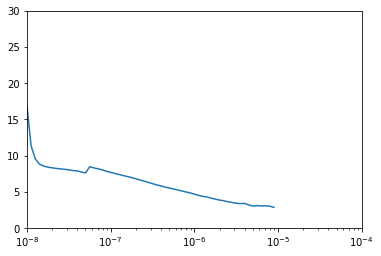

In [22]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [0]:
forecast = []
res = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
res = np.array(forecast)[:, 0, 0]


#plt.figure(figsize=(10, 6))

#plot_series(time_valid, x_valid)
#plot_series(time_valid, results)



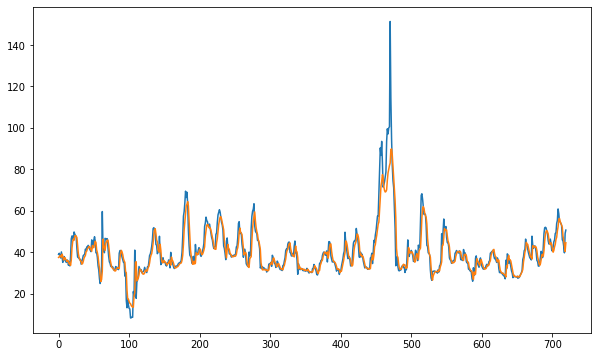

In [30]:
from matplotlib import pyplot
pyplot.figure(figsize=(10, 6))
pyplot.plot( x_valid)
pyplot.plot(res)
pyplot.show()


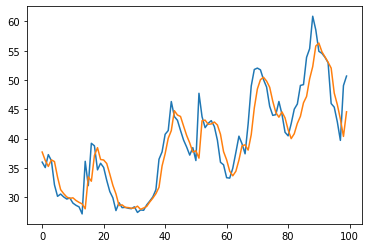

In [35]:
pyplot.plot(x_valid[-100:])
pyplot.plot(res[-100:])
pyplot.show()

In [36]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse,rmse
error1 = mse(x_valid, res)
error2 = rmse(x_valid, res)
error3 = mean_absolute_error(x_valid, res)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(x_valid), np.array(res)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
error4 = mean_absolute_percentage_error(x_valid, res)

print(f'MAE Error: {error3:11.10}') 
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print(f'MAPE Error: {error4:11.10}')

MAE Error: 2.970674384
MSE Error :   28.724103
RMSE Error: 5.359487195
MAPE Error: 7.117049726


<Figure size 432x288 with 0 Axes>

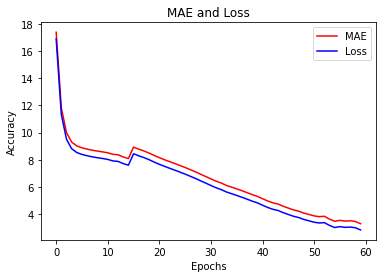

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [37]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

plt.figure()